## OBJECTIVE:
# DETECTING PNEUMONIA DISEASES BY PASSING CHEST XRAY SCAN OF DIFFERENT PATIENTS USING THE VGG19 CNN ARCHITECTURE

In [ ]:
# Loading all the Libraries which we will be using in our prediction
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split
import cv2
import zipfile
import os
from matplotlib import pyplot as plt
import random as rand
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import Counter

In [ ]:
# Extracting the Folders which has images of different classes
with zipfile.ZipFile('/content/drive/MyDrive/chest_xray.zip','r') as zip_file:
  zip_file.extractall('')

In [ ]:
# USING IMAGE DATA GENERATOR TO DO THE IMAGE AUGMENTATION ON OUR DATASET
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=  True)

test_datagen = ImageDataGenerator(rescale = 1./255) 

Loading the data
OUR DATASET CONTAINS 2 CLASSES OF IMAGES
1. NORMAL XRAY IMAGES OF PATIENTS
2. PNEUMONIA AFFECTED PATIENTS XRAY IMAGES

In [ ]:

train_data = train_datagen.flow_from_directory('/content/chest_xray/train', target_size = (224,224), batch_size = 32,
                                               class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [ ]:
test_data = test_datagen.flow_from_directory('/content/chest_xray/test', target_size = (224,224), batch_size = 32,
                                               class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [ ]:
# Names of all the classes present
all_classes = train_data.class_indices
print(all_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
counter =Counter(train_data.classes)

In [ ]:
# CHECKING THE NUMBER OF IMAGES WE HAVE FOR EACH CLASS
print(counter)
print(counter.values())

Counter({1: 3875, 0: 1341})
dict_values([1341, 3875])


In [ ]:
# TAKING THE MAX VALUE FROM OUR COUNTER VARIABLE WHICH WE WILL USING FURTHER TO INFER CLASS WEIGHTS
max_val = float(max(counter.values()))

In [ ]:
# ADDING WEIGHTS TO THE CLASS WHICH HAS LESS NUMBER OF SAMPLES , SO THAT THE CLASS WHICH HAS LESS NUMBER OF SAMPLES WILL GET BIT HIGHER WEIGHTAGE WHILE TRAINING SO THAT OUR MODEL CAN PREDICT BOTH THE CLASSES 
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [ ]:
# These are the class weights, as the class "NORMAL"  has less images so it got more weightage which we will use in the model fitting
print(class_weights)

{0: 2.889634601043997, 1: 1.0}


# PLOTTING THE IMAGES

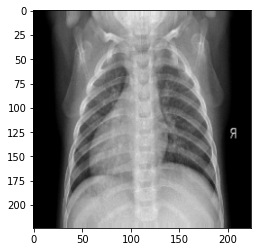

NORMAL


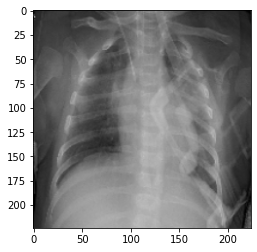

PNEUMONIA


In [ ]:
for j in range(len(train_data[0][1])):
  if list(train_data[0][1][j])[0]==1.:
    plt.imshow(train_data[0][0][j])
    plt.show()
    print(list(all_classes.keys())[0])
    break
for j in range(len(train_data[0][1])):
  if list(train_data[0][1][j])[1]==1.:
    plt.imshow(train_data[0][0][j])
    plt.show()
    print(list(all_classes.keys())[1])
    break

In [ ]:
# Loading the VGG19 model
vgg19 = VGG19(input_shape = (224,224,3), weights ='imagenet',include_top = False )

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
# don't train the existing weights: We will be using the the exisiting model weights as well for our model
for layers in vgg19.layers:
  layers.trainable = False

In [ ]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# ADDING OUR CUSTOM TOP LAYER TO OUR VGG19 MODEL AS OUR VGG19 MODEL WAS TRAINED ON 1000 CLASSES, WHILE IN OUR DATASET WE HAVE ONLY 2 CLASSES
flatten = Flatten()(vgg19.output)
dense = Dense(64, activation = 'relu')(flatten)
dense = Dense(32, activation = 'relu')(dense)
prediction = Dense(2, activation = 'softmax')(dense)

In [ ]:
#creating a model
model = Model(inputs = vgg19.input, outputs = prediction )

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# COMPILING THE MODEL

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
#executing the model
history = model.fit_generator(train_data, validation_data = (test_data), epochs = 20, verbose = 1, class_weight = class_weights)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
163/163 [==============================] - 142s 629ms/step - loss: 0.4719 - accuracy: 0.8694 - val_loss: 0.2779 - val_accuracy: 0.8878
Epoch 2/20
163/163 [==============================] - 99s 608ms/step - loss: 0.2532 - accuracy: 0.9306 - val_loss: 0.2420 - val_accuracy: 0.9199
Epoch 3/20
163/163 [==============================] - 104s 641ms/step - loss: 0.1996 - accuracy: 0.9475 - val_loss: 0.4813 - val_accuracy: 0.8526
Epoch 4/20
163/163 [==============================] - 99s 604ms/step - loss: 0.1901 - accuracy: 0.9482 - val_loss: 0.3016 - val_accuracy: 0.8814
Epoch 5/20
163/163 [==============================] - 98s 602ms/step - loss: 0.1730 - accuracy: 0.9544 - val_loss: 0.2364 - val_accuracy: 0.9087
Epoch 6/20
163/163 [==============================] - 99s 604ms/step - loss: 0.1591 - accuracy: 0.9592 - val_loss: 0.2664 - val_accurac

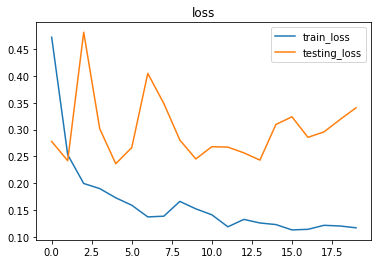

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

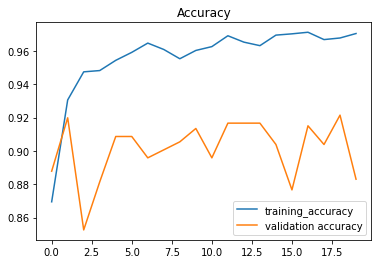

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# CHECKING THE CONFUSION MATRIX

Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred ,axis =1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(test_data.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['NORMAL','PNEUMONIA']
print(classification_report(test_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[108 126]
 [163 227]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.40      0.46      0.43       234
   PNEUMONIA       0.64      0.58      0.61       390

    accuracy                           0.54       624
   macro avg       0.52      0.52      0.52       624
weighted avg       0.55      0.54      0.54       624



In [ ]:
# SAVING OUR MODEL

model.save('model_pneumonia_detection.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

In [ ]:
# LOADING OUR MODEL JUST TO CHECK THE PREDICTION

model_pneumo = load_model('model_pneumonia_detection.h5')

In [ ]:
# PREDICTING A RANDOM IMAGE WHICH WE HAVE PICKED FROM THE VALIDATION DATASET
img1 = image.load_img('/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg',target_size = (224,224))
x = image.img_to_array(img1)
x = np.expand_dims(x, axis = 0)
img1_check = preprocess_input(x)

In [ ]:

classes = model.predict(img1_check)

In [ ]:

img2 = image.load_img('/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg',target_size = (224,224))
x = image.img_to_array(img2)
x = np.expand_dims(x, axis = 0)
img2_check = preprocess_input(x)

In [ ]:
classes = model.predict(img2_check)

In [ ]:
print(classes)

[[1.0000000e+00 1.7034447e-10]]


# DEPLOYING OUR MODEL USING STREAMLIT AND PYNGROK 

In [ ]:
# INSTALLING THE STREAMLIT
!pip install streamlit

     |████████████████████████████████| 7.8MB 19.7MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 174kB 37.3MB/s 
     |████████████████████████████████| 4.2MB 27.9MB/s 
     |████████████████████████████████| 112kB 38.6MB/s 
     |████████████████████████████████| 71kB 5.1MB/s 
     |████████████████████████████████| 122kB 38.2MB/s 
  Created wheel for blinker: filename=blinker-1.4-cp37-none-any.whl size=13476 sha256=cef407be8b836c75087dc9694f8f2982337fe835ca470bd8acc88cc30643d663
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
Successfully built blinker
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.5 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [ ]:
# INSTALLING PYNGROK MODULE
!pip install pyngrok

     |████████████████████████████████| 747kB 35.5MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.0.5-cp37-none-any.whl size=19262 sha256=0abc7b89b6d7fefd9b41ac34d06a9ed0c513bfb74b2bff4327a0d2e52d285835
  Stored in directory: /root/.cache/pip/wheels/0c/13/64/5ebbcc22eaf53fdf5766b397c1fb17c83f5775fdccf0ea1b88
Successfully built pyngrok


In [ ]:
# CREATING A NGROK FOLDER IN OUR DRIVE WHERE WE CAN STORE OUR NOHUP DATA
!mount --bind /content/drive/MyDrive /drive
!mkdir -p /drive/ngrok-ssh
!mkdir -p ~/.ssh

In [ ]:
!apt-get install ssh tmux vim

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tmux is already the newest version (2.6-3ubuntu0.2).
The following additional packages will be installed:
  libgpm2 ncurses-term openssh-server openssh-sftp-server python3-certifi
  python3-chardet python3-idna python3-pkg-resources python3-requests
  python3-six python3-urllib3 ssh-import-id vim-common vim-runtime xxd
Suggested packages:
  gpm molly-guard monkeysphere rssh ssh-askpass ufw python3-setuptools
  python3-cryptography python3-openssl python3-socks ctags vim-doc vim-scripts
The following NEW packages will be installed:
  libgpm2 ncurses-term openssh-server openssh-sftp-server python3-certifi
  python3-chardet python3-idna python3-pkg-resources python3-requests
  python3-six python3-urllib3 ssh ssh-import-id vim vim-common vim-runtime xxd
0 upgraded, 17 newly installed, 0 to remove and 39 not upgraded.
Need to get 7,876 kB of archives.
After this operation, 40.3 MB of additional d

In [ ]:
!cp /drive/ngrok-ssh/sshd_config /etc/ssh/sshd_config
!service ssh restart
!mkdir -p ~/.ssh

cp: cannot stat '/drive/ngrok-ssh/sshd_config': No such file or directory
 * Restarting OpenBSD Secure Shell server sshd
   ...done.


In [ ]:
!mkdir -p /drive/ngrok-ssh
%cd /drive/ngrok-ssh
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
!unzip -u ngrok-stable-linux-amd64.zip
!cp /drive/ngrok-ssh/ngrok /ngrok
!chmod +x /ngrok

/drive/ngrok-ssh
--2021-06-25 01:00:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.174.24.146, 3.223.73.198, 34.233.212.111, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.174.24.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  35.3MB/s    in 0.4s    

2021-06-25 01:00:55 (35.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


# USING STREAMLIT WE WILL DEPLOY OUR MODEL ONTO WEB

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from keras.models import load_model

st.set_option('deprecation.showfileUploaderEncoding',False)
@st.cache(allow_output_mutation=True)
def load_classfication_model():
  model = load_model('/content/model_pneumonia_detection.h5')
  return model

model = load_classfication_model()

st.write("""
          # PNEUMONIA DETECTION USING CNN
          """)

file = st.file_uploader("Please upload a Chest XRAY IMAGE",type = ["jpeg","jpg","png"])

import cv2
from PIL import Image, ImageOps
import numpy as np

def import_and_predict(image_data,model):

  size = (224,224)
  image = ImageOps.fit(image_data,size,Image.ANTIALIAS)
  img = np.asarray(image)
  img_reshape = img[np.newaxis,...]
  prediction = model.predict(img_reshape)

  return prediction

if file is None:
  st.text("Please upload an image file")
else:
  image = Image.open(file)
  st.image(image,use_column_width=True)
  predictions = import_and_predict(image,model)
  class_names = ['Normal','Pneumonia']
  string = "This particular image most likely is :"+class_names[np.argmax(predictions)]
  st.success(string)

Overwriting app.py


# BEFORE GOING FURTHER WE HAVE TO SIGNUP IN NGROK WEBSITE, FROM WHERE WE CAN GET OUR AUTHENTICATION TOKEN WHICH WE WILL BE USING TO DEPLOY OUR MODEL

HERE IS THE SITE WHERE YOU CAN SIGN UP: https://ngrok.com/

In [ ]:
!ngrok authtoken 1uQ0PW5QlVLTkUV4g173FKcCTvx_2pGUeCtN1aeBJokxhUUzY

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# THIS IS THE DEFAULT SERVER WHERE OUR STREAMLIT MODEL WILL GET DEPLOYED
!nohup streamlit run --server.port 80 app.py &

nohup: appending output to 'nohup.out'


In [ ]:
# USING PYNGROK SO THAT WE CAN CHECK THE URL WHERE OUR MODEL IS BEING DEPLOYED
from pyngrok import ngrok
url = ngrok.connect(port = 8501)
url

<NgrokTunnel: "http://94d1e4cfe70f.ngrok.io" -> "http://localhost:80">

In [ ]:
# RUN THIS CELL IF YOU WANT TO KILL ANY TUNNELS WHICH ARE RUNNING ON YOUR ID
ngrok.kill()